# Getting Heads 2

This notebook aims to develop a new method of head detection using insights gained from the first version of this data. This new effort improves on the previous one in two main ways:

* head selection is performed using Text Fabric templates, which offers a clearer, more transparent way to select and filter data
* aims to track and address all edge cases

Most of the rationale and rules generated in [getting_heads.ipynb](getting_heads.ipynb) are carried over to this present notebook.

In [1]:
from tf.extra.bhsa import Bhsa
from IPython.display import display
import collections, random, csv, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
A = Bhsa(hoist=globals(), silent=True)
print(f'running version {A.version} of BHSA...')

running version c of BHSA...


# Defining Heads

The basic definition of a phrase head from the previous version is carried over here, which is:
> the word with a part of speech after which a phrase type is named

As applied in the previous effort, this includes a secondary criterion:
> the word which semantically determines grammatical agreement

This latter case thus excludes quantifiers such as כל and cardinal numbers that are in construct or attribution to a given word.

From the point of view of the ETCBC database, heads can be extracted using the `subphrase` object and its relations. These relations are not always coded in a transparent or beneficial way. But they are at least useful enough to disambiguate independent words from dependent words. From the ETCBC database perspective, we add a third criterion:
> a word contained in an independent subphrase or a subphrase only dependent upon a quantifier


## Tracking Head Selection

Using the guiding principles listed above, we will follow a process of deduction for assigning heads to phrases. We select all phrases to track which heads are accounted for.

In [3]:
remaining_phrases = set(result[0] for result in A.search('phrase'))
covered_phrases = set()
remaining_types = list(feat[0] for feat in F.typ.freqList(nodeTypes='phrase'))

  0.08s 253207 results


All phrase to head assignments will be made in the dictionary below.

In [4]:
phrase2heads = collections.defaultdict(set)

The functions below programmatically record the heads in `phrase2heads` and remove them from the remaining set. `query_heads` iterates through a dictionary of queries and calls `record_head` on each result. `heads_status` provides a simple readout of what phrases remain to be analyzed.

In [5]:
def record_head(phrase, head, mapping=phrase2heads, remaining=remaining_phrases, covered=covered_phrases):
    '''
    Simple function to track phrases
    with heads that are accounted for
    and to modify the phrase2heads
    dict, which is a mapping from a phrase
    node to its head nodes.
    '''
    # try/except accounts for phrases with plural heads, 
    # one of which is already recorded
    try:
          remaining.remove(phrase)
    except: 
        pass
    
    if F.otype.v(phrase) == 'word':
        raise Exception(f'node {phrase} is a word not a phrase!')
    
    mapping[phrase].add(head) # record it
    covered.add(phrase)
    
def query_heads(querydict, phrasei=0, headi=1, sets={}):
    '''
    Runs queries on phrasetype/query dict.
    Reports results.
    Adds results.
    
    phrasei - the index of the phrase result in the search template.
    headi - the index of the head result in the search template.
    sets - custom sets for TF search
    '''
    for phrasetype, query in querydict.items():
        print(f'running query on {phrasetype}')
        results = A.search(query, silent=True, sets=sets)
        print(f'\t{len(results)} results found')
        for res in results:
            phrase, head = res[phrasei], res[headi]
            record_head(phrase, head)
            
def heads_status():
    # simply prints accounted vs unaccounted heads
    print(f'{len(covered_phrases)} phrases matched with a head...')
    print(f'{len(remaining_phrases)} phrases remaining...')

# Simple Heads

The selection of heads for certain phrase types is very straightforward. Those are defined in the templates below and are subsequently applied. These phrase types are selected based on the survey of their subphrase relations as found in the old notebook.

In [6]:
simp_heads = dict(

PPrP = '''
% personal pronoun

phrase typ=PPrP
    word pdp=prps

''',

DPrP = '''
% demonstrative pronoun

phrase typ=DPrP
    word pdp=prde

''',

InjP = '''
% interjectional

phrase typ=InjP
    word pdp=intj

''',

NegP = '''
% negative

phrase typ=NegP
    word pdp=nega

''',

InrP = '''
% interrogative

phrase typ=InrP
    word pdp=inrg

''',
    
IPrP = '''
% interrogative pronoun

phrase typ=IPrP
    word pdp=prin

''',

) # end of dictionary

### Make Queries, Record Heads, See What Remains

Here we run the queries and run `record_head` over each result. In all of the templates the head is the second item in the result tuple.

In [7]:
query_heads(simp_heads)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on PPrP
	4392 results found
running query on DPrP
	791 results found
running query on InjP
	1883 results found
running query on NegP
	6742 results found
running query on InrP
	1291 results found
running query on IPrP
	798 results found

 <><><><><><><><><><><><><><><><><><><><> 

15866 phrases matched with a head...
237341 phrases remaining...


### Find Remaining Phrases

What phrases with the above types remain unaccounted for?

In [8]:
unaccounted_simp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) in simp_heads)
len(unaccounted_simp)

0

In [9]:
for typ in simp_heads:
    remaining_types.remove(typ)
print(remaining_types)

['VP', 'PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


# Mostly Simple Heads

The next set of heads require a bit more care since they can contain a bigger variety of relationships.

## VP
There is only one complication for the VP: that is that there is one VP that has more than one verb:

In [10]:
mult_verbs = A.search('''

phrase typ=VP
/with/
    word pdp=verb
    < word pdp=verb
/-/
''')
A.show(mult_verbs, condenseType='clause', withNodes=True)

  1.27s 1 result




**clause** *1*



The template below excludes this case without ignoring VP's that do not necessarily begin with a verb.

In [11]:
VP = '''

phrase typ=VP
    
    head:word pdp=verb
    
    /without/
    phrase
        word pdp=verb
        < head
    /-/

'''

VP_search = A.search(VP)

for phrase, head in VP_search:
    record_head(phrase, head)
    
heads_status()

  1.54s 69024 results
84890 phrases matched with a head...
168317 phrases remaining...


### VP Sanity Check

We double check that the indicated phrase above only has one head.

In [12]:
phrase2heads[893310]

{403602}

See what's left...

In [13]:
unaccounted_vp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'VP')
len(unaccounted_vp)

0

In [14]:
remaining_types.remove('VP')
print(remaining_types)

['PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


## CP

The conjunction phrase is relatively straightforward. But there are 1140 cases where the conjunction is technically headed by a preposition in the ETCBC data. These are phrases such as בטרם and בעבור (see the more detailed analysis in the prev. notebook). It is not clear at all why the ETCBC encodes these as conjunction phrases. This is almost certainly a confusion of the formal `typ` value and the functional `function` label (with a value of `Conj`). Nevertheless, here we make a choice to select the preposition as the true head.

In a BHSA2, these cases ought to be repaired.

In [15]:
cp_heads = dict(

conj = '''

phrase typ=CP
/without/
    word pdp=prep
/-/
    head:word pdp=conj
    /without/
    phrase_atom
        word pdp=conj
        <: head
    /-/

''',
    
prep_conj = '''

phrase typ=CP
    =: word pdp=prep

'''

)



In [16]:
query_heads(cp_heads)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on conj
	51341 results found
running query on prep_conj
	1140 results found

 <><><><><><><><><><><><><><><><><><><><> 

137371 phrases matched with a head...
115836 phrases remaining...


### CP Sanity Check

In [17]:
unaccounted_cp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'CP')
len(unaccounted_cp)

0

In [18]:
remaining_types.remove('CP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP', 'AdjP']


## AdjP

The adjective phrase always occurs with a word that has a `pdp` of adjective: 

In [19]:
A.search('''

phrase typ=AdjP
/without/
    word pdp=adjv
/-/

''')

  0.63s 0 results


[]

By playing with the `head:word pdp=` value below, I ascertain that there are 8 uses of `subs` as a head in this phrase type, and 1 use of `advb` as a head. These variants are due to the phrase containing multiple heads, with the first having a `pdp` of `adjv`, formally making the phrase an `AdjP`. 

The selection criteria is as follows. We want all cases in an adjective phrase where the word has a `pdp` of `adjv`, `subs`, or `advb`. The head candidate must not be found in a modifying subphrase, defined as `rela=adj|atr|rec|mod|dem` (remember that a word can often occur in multiple subphrases); and the only acceptable values for phrase_atom and subphrase relations are either `NA` (no relation), or `Para`/`par` (coordinate relation). In this latter case, it is expected here that the first requirement will prevent spurious parallel results (that is, words that are parallel not to a head but to a modiying element).

The requirements are set in the pattern below.

In [20]:
AdjP = '''

phrase typ=AdjP
    phrase_atom rela=NA|Para
        head:word pdp=adjv|subs|advb
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
'''
AdjP = A.search(AdjP)

for res in AdjP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.45s 1871 results
139120 phrases matched with a head...
114087 phrases remaining...


In [21]:
unaccounted_AdjP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdjP')
len(unaccounted_AdjP)

0

In [22]:
remaining_types.remove('AdjP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP']


## AdvP

The adverb phrase has similar internal relations to AdjP. Thus, we apply the same basic template search.

By modifying `pdp=` parameter, I have found 2 examples of a preposition in the AdvP, which is caused by a prepositional phrase_atom coordinated with the `AdvP` phrase atom. These mixed cases must be dealt with imperfectly by taking the preposition head literally. It is then up to the user of the heads feature to include/exclude cases such as these, or to depend on the phrase_atoms.

There are two cases where an `inrg` serves as a head element. These are incorrect encodings, as they belong under their own phrase type of `InrP`. These should be fixed in BHSA2. For now the `inrg` is excluded as a phrase head as they are followed by a `advb` which is probably triggering these phrases' classification.

There is one case in sentence 68 from Exodus 8:20 where a כל quantifier is incorrectly identified as a phrase head. This is because it precedes a prepositional element. That case is also excluded below.

In [23]:
AdvP = '''

phrase typ=AdvP
    phrase_atom rela=NA|Para
        head:word pdp=advb|subs|nmpr|prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a prepositional form
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
AdvP = A.search(AdvP)

for res in AdvP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.79s 5776 results
144779 phrases matched with a head...
108428 phrases remaining...


In [24]:
unaccounted_AdvP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdvP')
len(unaccounted_AdvP)

0

In [25]:
remaining_types.remove('AdvP')
print(remaining_types)

['PP', 'NP', 'PrNP']


## PP

The same method used above applies to prepositional phrases.

In [26]:
PP = '''

phrase typ=PP
    phrase_atom rela=NA|Para
        head:word pdp=prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
PP = A.search(PP)

for res in PP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.48s 61544 results
202261 phrases matched with a head...
50946 phrases remaining...


In [27]:
unaccounted_PP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'PP')
len(unaccounted_PP)

0

In [28]:
remaining_types.remove('PP')
print(remaining_types)

['NP', 'PrNP']


## NP and PrNP

The noun phrase is the most complicated for head selection due to the presence of quantifers. 

In [29]:
custom_quants = {'KL/', 'M<V/', 'JTR/', # quantifier lexemes, others?
                 'M<FR/', 'XYJ/'}
quantlexs = '|'.join(custom_quants)

# for the Hebrew idiom: בנ + quantifier for age
son_quantifiers = set(res[0] for res in A.search('''

word lex=BN/ st=c nu=sg
<: word ls=card

'''))

# for use as quantifier set
quantifiers = set(w for w in F.otype.s('word')
                  if F.lex.v(w) in custom_quants
                  or F.ls.v(w) == 'card')

quantifiers |= (son_quantifiers)

  0.81s 127 results


In [30]:
NP_heads = dict(
    
NP_noqant = f'''

phrase typ=NP|PrNP|DPrP|PPrP
    phrase_atom rela=NA|Para
        head:word pdp=subs|adjv|nmpr|prde|prps
        
% word is not equal to a quantifier
        /without/
        = quant
        /-/
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
        /without/
        phrase_atom
            word pdp=prep
            <: word pdp=art
            <: head
        /-/
''',

NP_quant_alone = f'''

phrase typ=NP|PrNP
    phrase_atom rela=NA|Para
        quantifier:quant
            
% quantifier does not precede a quantified element
        /without/
        phrase_atom
            quantifier
            < w1:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
            
% look to see whether potential quantified element is not preceded by prep 
            /without/
            word pdp=prep
            <: word pdp=art
            <: w1
            /-/
            /without/
            word pdp=prep
            <: w1
            /-/ 
        /-/
        
% ensure quantifer is not in a quantifying chain
        /without/
        phrase
            phrase_atom rela=NA|Para
            /with/
                word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
                <: word ls=card
            /or/
                word ls=card
                <: word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
            /or/
                word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
                <: word pdp=art
                <: word ls=card
            /or/
                word ls=card
                <: word pdp=art
                <: word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
            /-/
            quantifier ls=card
        /-/

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: quantifier
        /-/

% ensure quantifier is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: quantifier
        /-/
        /without/
        phrase_atom
            word pdp=prep
            <: word pdp=art
            <: quantifier
        /-/

''',

NP_quantified = f'''

phrase typ=NP|PrNP
    phrase_atom rela=NA|Para
    
% phrase atom must have quantifier as formal head:
    /with/
        quantifier:quant
        
% quantifier precedes a quantified element
        /with/
        phrase_atom
            quantifier
            < word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
        /-/

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
    /-/
    
        head:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card

% require head word to be construct and adjacent to any quantifier in the phrase atom:
        /with/
        phrase_atom
            quant
            <: head

        /or/
        phrase_atom
            quant
            <: word pdp=art
            <: head
        /-/
    
''')

query_heads(NP_heads, headi=2, sets={'quant': quantifiers})
print('\n', '<>'*20, '\n')
heads_status()

running query on NP_noqant
	57147 results found
running query on NP_quant_alone
	1691 results found
running query on NP_quantified
	3557 results found

 <><><><><><><><><><><><><><><><><><><><> 

253205 phrases matched with a head...
2 phrases remaining...


There are only 2 phrases left. Let's have a look at the remaining phrases...

In [31]:
for phrase in list(remaining_phrases)[:100]:
    print('{} {}:{}'.format(*T.sectionFromNode(phrase)))
    print(f'phrase {F.number.v(phrase)}')
    A.prettyTuple((phrase,), seqNumber=phrase, withNodes=True, condenseType='clause')

Psalms 59:4
phrase 4




**Result** *842047*



Proverbs 23:29
phrase 2




**Result** *865764*



In [32]:
patched_heads = dict(

patch1 = '''

book book@en=Psalms
    chapter chapter=59
        verse verse=4
            phrase number=4
                word lex=L>
''',

patch2 = '''

book book@en=Proverbs
    chapter chapter=23
        verse verse=29
            phrase number=2
                word lex=>WJ
'''

) # end of dict

query_heads(patched_heads, phrasei=3, headi=4)
print('\n', '<>'*20, '\n')
heads_status()

running query on patch1
	2 results found
running query on patch2
	1 results found

 <><><><><><><><><><><><><><><><><><><><> 

253207 phrases matched with a head...
0 phrases remaining...


# Evaluating Heads v.2

## Vs. Stephen Ku's Evaluation of `headsv.1`


Stephen Ku has kindly and laboriously documented missing head cases for heads v.1 (from April 21, see doc [here](https://docs.google.com/document/d/1miNomMzlutDu-cVVXa153D7kO03El-J1-CWjt6N5xJk/edit)). Below, I display Stephen's feedback and check to make sure his examples are indeed cured.

In [33]:
ku_eval = pd.read_csv('stephen_ku_heads_eval.csv', header=1).fillna('')
ku_eval['Decision'] = ''
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,
5,Num 31:17,missing כֹּל before אִשָּׁה,,
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,


In [34]:
abb2book = {'Gen': 'Genesis', 
            'Num':'Numbers', 
            'Deut': 'Deuteronomy',
            'Judg': 'Judges',
            '1_Sam': '1_Samuel',
            '1_Kgs': '1_Kings',
            'Isa': 'Isaiah',
            'Ps': 'Psalms',
            'Job': 'Job',
            'Prov': 'Proverbs',
            '2_Chr': '2_Chronicles'}

my_decisions = {'not yet going out of clause boundaries': {0,1, 2 ,6, 8, 11, 12 , 13, 16, 18},
                'fixed': {3, 4, 5, 7, 9, 10, 14, 15, 17, 19},}

for decision, numbers in my_decisions.items():
    for num in numbers:
        ku_eval.loc[num]['Decision'] = decision
        

for i, ref in enumerate(ku_eval.Verse):

    book, ch_vs = ref.split() if not re.match('^\d', ref) else ref.replace(' ', '_', 1).split()
    book = abb2book[book.strip()]
    chapter, verse = ch_vs.split(':')
    
    # get TF ref
    tf_node = T.nodeFromSection((book, int(chapter), int(verse)))
    for phrase in L.d(tf_node, 'phrase'):
        if 'KL/' in [F.lex.v(w) for w in L.d(phrase, 'word')]:
            print(ref)
            print(f'v1 issue: {ku_eval.Issue[i]}')
            print(f'v2 update: {ku_eval.Decision[i]}')
            A.prettyTuple((phrase,)+tuple(phrase2heads[phrase]), seqNumber=f'Ku Eval {i}', condenseType='clause', withNodes=True)

Gen 39:4
v1 issue: missing יֵשׁ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 0*



Num 5:2
v1 issue: missing two כֹּל’s (the one before צָר֖וּעַ and the one before זָ֑ב)
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 1*



Num 5:2
v1 issue: it’s able to find the last כֹ֖ל but not טָמֵא following it
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 2*



Num 31:7
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 3*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Deut 25:18
v1 issue: missing חשׁל after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 6*



Judg 13:4
v1 issue: missing טָמֵֽא after כֹּל
v2 update: fixed




**Result** *Ku Eval 7*



1 Sam 14:36
v1 issue: missing טוֹב after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 8*



1 Kgs 11:15
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 9*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



Isa 43:7
v1 issue: missing הַנִּקְרָ֣א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 11*



Ps 73:27
v1 issue: missing זֹונֶ֥ה after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 12*



Ps 119:118
v1 issue: missing שֹׁוגִ֣ים after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 13*



Job 40:11
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 14*



Job 40:12
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 15*



Prov 6:29
v1 issue: missing נֹּגֵ֥עַ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 16*



Prov 20:8
v1 issue: missing רָֽע after כֹּל
v2 update: fixed




**Result** *Ku Eval 17*



2 Chr 13:9
v1 issue: missing בָּ֗א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 18*



2 Chr 22:1
v1 issue: missing רִאשֹׁנִים֙ after כֹּל
v2 update: fixed




**Result** *Ku Eval 19*



By way of overview, here are the previous issues and the new decisions.

In [35]:
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,not yet going out of clause boundaries
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,not yet going out of clause boundaries
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,not yet going out of clause boundaries
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,fixed
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,fixed
5,Num 31:17,missing כֹּל before אִשָּׁה,,fixed
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,not yet going out of clause boundaries
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,fixed
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,not yet going out of clause boundaries
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,fixed


As indicated in the decisions, I have decided to not yet extend beyond the clause boundaries for situations where כל quantifies an entire clause. That step may require further methodological evaluation about the role of clause and phrase embeddings. This is a task that is better suited within a whole new data model, such as BHSA2 can provide.

All other cases have been fixed by the new heads selection procedures. This already shows that the new heads performs better than the previous version.

## Statistical Evaluation

Below I provide statistical counts and visualizations for the head assignments. 

In [36]:
typ2pdpcounts = collections.defaultdict(lambda: collections.Counter())

for phrase, heads in phrase2heads.items():
    typ = F.typ.v(phrase)
    pdps = [F.pdp.v(head) for head in heads]
    typ2pdpcounts[typ].update(pdps)
    
typ2pdpcounts = pd.DataFrame(typ2pdpcounts).fillna(0)

Parts of Speech for PPrP


,PPrP
prps,4392.0
subs,224.0
nmpr,20.0


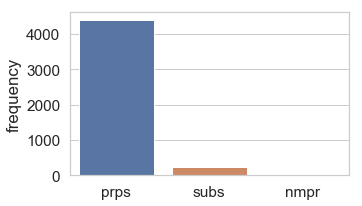

Parts of Speech for DPrP


,DPrP
prde,791.0


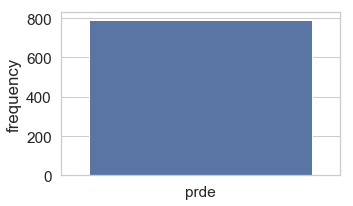

Parts of Speech for InjP


,InjP
intj,1883.0


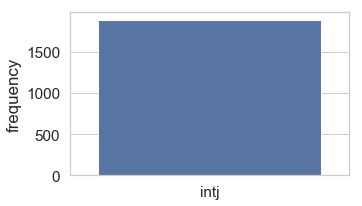

Parts of Speech for NegP


,NegP
nega,6742.0


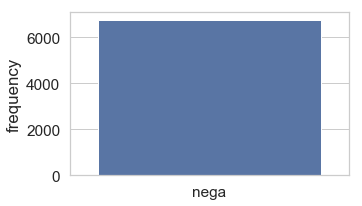

Parts of Speech for InrP


,InrP
inrg,1291.0


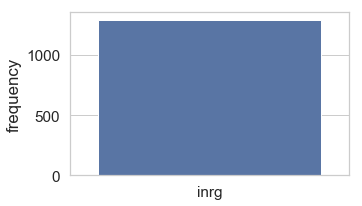

Parts of Speech for IPrP


,IPrP
prin,798.0


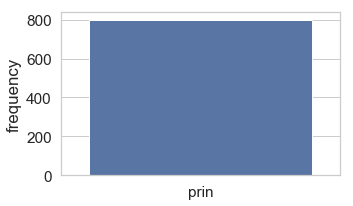

Parts of Speech for VP


,VP
verb,69024.0


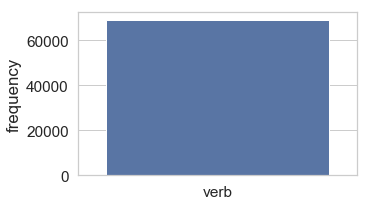

Parts of Speech for CP


,CP
conj,51341.0
prep,1140.0


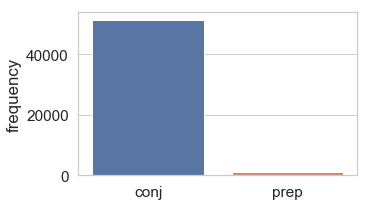

Parts of Speech for AdjP


,AdjP
adjv,1866.0
subs,4.0
advb,1.0


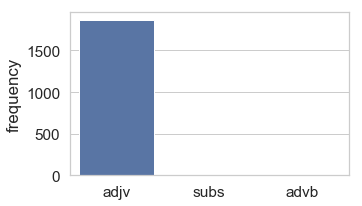

Parts of Speech for AdvP


,AdvP
advb,5172.0
subs,368.0
nmpr,234.0
prep,2.0


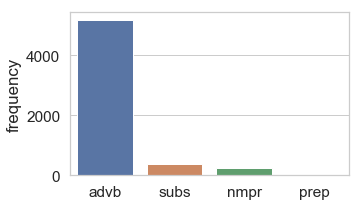

Parts of Speech for PP


,PP
prep,61544.0


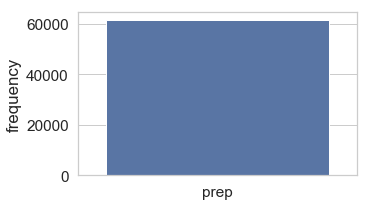

Parts of Speech for NP


,NP
subs,44670.0
nmpr,150.0
adjv,127.0
prde,50.0
prps,4.0
nega,2.0
intj,1.0


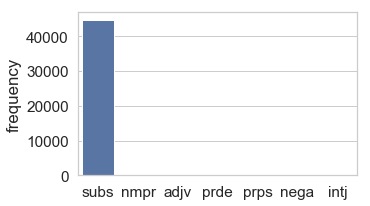

Parts of Speech for PrNP


,PrNP
nmpr,11630.0
subs,337.0
prps,1.0


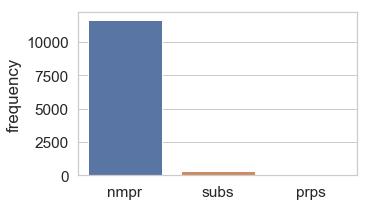

In [37]:
sns.set(style='whitegrid', font_scale=1.4)

for typ in typ2pdpcounts:
    positive = typ2pdpcounts[typ][typ2pdpcounts[typ] > 0].sort_values(ascending=False)
    
    print(f'Parts of Speech for {typ}')
    display(pd.DataFrame(positive))
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x=positive.index, y=positive)
    plt.ylabel('frequency')
    plt.show()

## Evaluating Quantifiers

By far, quantifiers are the most tricky of issues involved in picking out heads. Let's evaluate how many and which quantifiers have been selected.

In all cases, a quantifier should only be selected if it is not followed by a quantified noun. These quantifiers are selected with the `NP_quant_alone` query above, which identified 1691 cases. A quantifier should not have been selected in any other case.

In [38]:
len([head for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) in {'NP', 'PrNP'}]) - 1691

0

This is a good result. Let's check whether there are quantifiers in other phrase types.

In [39]:
A.show([(phrase, head) for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) not in {'NP', 'PrNP'}], condenseType='phrase', withNodes=True)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*



These quantifiers are all well-chosen. 

Next, I want to check whether there are any cases of a cardinal number and a substantive occuring together as head elements. These combinations often identify mismatched quantifiers.

In [40]:
card_mix = [(phrase,)+tuple(heads) for phrase, heads in phrase2heads.items()
                 if [w for w in heads if F.ls.v(w) == 'card']
                 and [w for w in heads if F.ls.v(w) != 'card']]

len(card_mix)

2

In [41]:
A.show(card_mix, condenseType='phrase', withNodes=True, end=100)



**phrase** *1*





**phrase** *2*



It is good that there is only 2 such cases. Both of these cases appear to be permissible combinations of quantifiers and nominals. In the first case, it is perhaps conceivable that the quantifier should be omitted, and זכן be selected instead. However, such a situation is a semantic choice that cannot be easily automated. There are many additional concerns that this method would need to address. In the second case the selection is well-made, because פעם here functions as a quantifier meaning "once".

Next, I want to know whether any cardinal quantifiers have unfairly been excluded from head roles by the strict requirements for standalone quantifiers. This would occur in phrases that only contain standalone quantifiers. This will require a search of its own, followed by a comparison of the search's heads with the selected heads.

In [42]:
all_cards = A.search(f'''

phrase typ=NP|PrNP

% all non-conj./art. words in phrase are cardinals
/where/
    word pdp#conj|art
/have/
    ls=card
/-/

    phrase_atom rela=NA|Para
        quantifier:quant

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: quantifier
        /-/

% ensure quantifier is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: quantifier
        /-/
        /without/
        phrase_atom
            word pdp=prep
            <: word pdp=art
            <: quantifier
        /-/
''', sets={'quant': quantifiers})

all_cards_heads = set(res[2] for res in all_cards)
select_cards_heads = set(head for phrase, heads in phrase2heads.items() for head in heads if F.ls.v(head) == 'card')

len(all_cards_heads - select_cards_heads) 

  1.21s 1031 results


0

This is a good result. The search found 1031 phrase heads in cardinal-only phrases. All of these heads are contained in the `heads2` dataset. 

Note that the `NP_quant_alone` pattern found more, with 1691. This is expected since `NP_quant_alone` is a more sophisticated search that checks between phrase atoms for various relations. We have already tested above to make sure those selections are valid. But just to be sure, which results did the `all_cards` pattern above not find? Below is a small sampling. They often have to do with additional modifiers on the cardinal number contained in a separate phrase_atom.

In [43]:
test = [(L.u(head, 'phrase')[0],)+tuple(phrase2heads[L.u(head, 'phrase')[0]]) for head in select_cards_heads - all_cards_heads]

A.show(test, condenseType='phrase', withNodes=True, end=5)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*



## Random Evaluations

We have examined methodically the different aspects of the selected heads, including their statistical distribution in terms of parts of speech, as well as looking for mixed or missed heads within quantifiers. Now we turn to a less methodical, but nonetheless important, evaluation measure: that of random sampling and manual inspection. The code below aims to produce the most varied sets of manual sampling, accross a wide array of phrase types. Since some phrase types are statistically dominant, the code selects a random phrase type that is then used to select a random node of that type. The algorithm runs until producing 100 random samples, with no duplicates allowed. The sample set can be re-shuffled with new random results by running the first cell before displaying the results.

There is also an option to pick results with more than a given number of heads, to show more complex examples.

In [44]:
# RUNNING THIS REMOVES PREVIOUSLY DISPLAYED RESULTS

min_words = 2
min_heads = 2

type2headresults = collections.defaultdict(list) # map types to result nodes
maxlength = collections.defaultdict(lambda: collections.defaultdict(int))
for phrase, heads in phrase2heads.items():
    typ = F.typ.v(phrase)
    type2headresults[typ].append((phrase,)+tuple(heads))
    phrase_len, head_len = len(L.d(phrase,'word')), len(heads)
    if phrase_len > maxlength[typ]['phrase']:
        maxlength[typ]['phrase'] = phrase_len
    if head_len > maxlength[typ]['head']:
        maxlength[typ]['head'] = head_len

samples = set() # to fill with 100
while len(samples) < 100:
        typ = random.choice(list(type2headresults.keys()))
        while maxlength[typ]['phrase'] < min_words or maxlength[typ]['head'] < min_heads: # don't pick type without size threshold
            typ = random.choice(list(type2headresults.keys()))
            
        choice = random.choice(type2headresults[typ])
        while len(L.d(choice[0], 'word')) < min_words or len(choice[1:]) < min_heads:
            choice = random.choice(type2headresults[typ])
        samples.add(choice)

<br>

In [45]:
for sp in L.d(758918, 'subphrase'):
    print(sp, F.rela.v(sp), E.mother.f(sp), T.text(sp))

1350514 NA () בֶּן־
1350515 rec (186493,) שְׁלֹמֹה֙ 
1350516 NA () מֶ֣לֶךְ 
1350517 rec (186495,) יְהוּדָ֔ה 
1350518 NA () כָּל־
1350523 rec (186499,) בֵּ֥ית יְהוּדָ֖ה וּבִנְיָמִ֑ין 
1350519 NA () בֵּ֥ית 
1350522 rec (186500,) יְהוּדָ֖ה וּבִנְיָמִ֑ין 
1350520 NA () יְהוּדָ֖ה 
1350521 par (1350520,) בִנְיָמִ֑ין 
1350524 NA () יֶ֥תֶר 
1350525 rec (186505,) הָעָ֖ם 


In [46]:
A.show(samples, condenseType='phrase', withNodes=True)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*





**phrase** *20*





**phrase** *21*





**phrase** *22*





**phrase** *23*





**phrase** *24*





**phrase** *25*





**phrase** *26*





**phrase** *27*





**phrase** *28*





**phrase** *29*





**phrase** *30*





**phrase** *31*





**phrase** *32*





**phrase** *33*





**phrase** *34*





**phrase** *35*





**phrase** *36*





**phrase** *37*





**phrase** *38*





**phrase** *39*





**phrase** *40*





**phrase** *41*





**phrase** *42*





**phrase** *43*





**phrase** *44*





**phrase** *45*





**phrase** *46*





**phrase** *47*





**phrase** *48*





**phrase** *49*





**phrase** *50*





**phrase** *51*





**phrase** *52*





**phrase** *53*





**phrase** *54*





**phrase** *55*





**phrase** *56*





**phrase** *57*





**phrase** *58*





**phrase** *59*





**phrase** *60*





**phrase** *61*





**phrase** *62*





**phrase** *63*





**phrase** *64*





**phrase** *65*





**phrase** *66*





**phrase** *67*





**phrase** *68*





**phrase** *69*





**phrase** *70*





**phrase** *71*





**phrase** *72*





**phrase** *73*





**phrase** *74*





**phrase** *75*





**phrase** *76*





**phrase** *77*





**phrase** *78*





**phrase** *79*





**phrase** *80*





**phrase** *81*





**phrase** *82*





**phrase** *83*





**phrase** *84*





**phrase** *85*





**phrase** *86*





**phrase** *87*





**phrase** *88*





**phrase** *89*





**phrase** *90*





**phrase** *91*





**phrase** *92*





**phrase** *93*





**phrase** *94*





**phrase** *95*





**phrase** *96*





**phrase** *97*





**phrase** *98*





**phrase** *99*





**phrase** *100*



# `obj_prep`

The feature `prep_obj` in `v.1` was an edge feature from a word to its governing preposition. As is done with the nouns above, this would would be a nominal element that is disambiguated from its quantifiers. Since there is no dependency of a prepositional object, the nominal templates developed above can be used with the single change that the phrase type is a `PP` or `CP` (which also has prepositional objects!). 

Since `v.2` will encode edges from words to phrases rather than the other way around, this feature will encode an edge from the object to the preposition, hence the new feature name.

<hr>

In [159]:

preps = [w for w in F.otype.s('word') if F.pdp.v(w) == 'prep']

# add special preps:
preps.extend(A.search('''

prep:word lex=BD/
/with/
phrase_atom
    word pdp=prep lex=L
    <: prep
/-/

''', shallow=True))

preps.extend(A.search('''

prep:word lex=PNH/
/with/
phrase_atom
    word pdp=prep
    <: prep
/-/

''', shallow=True))

PP_heads = dict(
    
PP_noqant = f'''

phrase_atom
    head:word pdp#conj|art|prep

% word follows a preposition
    /with/
    phrase_atom
        w1:prep prs=absent
        < head
        w1 # head
    /-/

% word is not equal to a quantifier
    /without/
    = quant
    /-/
    
% exclude uses as modifier:
    /without/
    subphrase rela=adj|atr|mod|dem
        head
        w1:word
        /without/
        phrase_atom
            prep
            <: w1
        /-/
        /without/
        phrase_atom
            prep
            <: word pdp=art
            <: w1
        /-/
        head = w1
    /-/

% exclude rec relations to non-prepositions
    /without/
    word
    /without/
    = prep
    /-/
    <mother- subphrase rela=rec
        head
        w1:word
        /without/
        phrase_atom
            prep
            <: w1
        /-/
        /without/
        phrase_atom
            prep
            <: word pdp=art
            <: w1
        /-/
        head = w1
    /-/

% ensure word is not immediately preceded by a construct form
    /without/
    phrase_atom
        word st=c
        /without/
        = prep
        /-/
        <: head
    /-/

''',

PP_quant_alone = f'''

phrase_atom
    quantifier:quant

% word follows a preposition
    /with/
    phrase_atom
        prep prs=absent
        < quantifier
    /-/

% quantifier does not precede a quantified element
    /without/
    phrase_atom
        quantifier prs=absent
        < w1:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
        /without/
        = prep
        /-/
    /-/

% ensure quantifer is not in a quantifying chain
    /without/
    phrase_atom
    /with/
        word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
        /without/
        = prep
        /-/
        <: word ls=card
    /or/
        word ls=card
        <: word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
        /without/
        = prep
        /-/
    /or/
        word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
        /without/
        = prep
        /-/
        <: word pdp=art
        <: word ls=card
    /or/
        word ls=card
        <: word pdp=art
        <: word pdp=subs|adjv|nmpr|prde|prps lex#{quantlexs} ls#card
        /without/
        = prep
        /-/
    /-/
        quantifier ls=card prs=absent
    /-/

% exclude uses as modifier:
    /without/
    subphrase rela=adj|atr|rec|mod|dem
        quantifier
        w1:word
        /without/
        phrase_atom
            prep
            <: w1
        /-/
        /without/
        phrase_atom
            prep
            <: word pdp=art
            <: w1
        /-/
        quantifier = w1
    /-/
''',

PP_quantified = f'''

phrase_atom

% phrase atom must have quantifier as formal head:
/with/
    quantifier:quant

% word follows a preposition
    /with/
    phrase_atom
        w1:prep prs=absent
        < quantifier
    /-/

% quantifier precedes a quantified element
    /with/
    phrase_atom
        quantifier
        < word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
    /-/

% exclude uses as modifier:
    /without/
    subphrase rela=adj|atr|rec|mod|dem
        quantifier
        w1:word
        /without/
        phrase_atom
            prep
            <: w1
        /-/
        /without/
        phrase_atom
            prep
            <: word pdp=art
            <: w1
        /-/
        quantifier = w1
    /-/
/-/

    head:word pdp#conj|art lex#{quantlexs} ls#card

% require head word to be construct and adjacent to any quantifier in the phrase atom:
    /with/
    phrase_atom
        quant
        <: head
    /or/
    phrase_atom
        quant
        <: word pdp=art
        <: head
    /-/
    
% word follows a preposition
    /with/
    phrase_atom
        prep prs=absent
        < head
    /-/

''',
    
PP_to_PP = '''

phrase_atom
    obj:prep
    /with/
    phrase_atom
        prep
        <: obj
    /-/
''',
    
PP_to_conj = '''

phrase_atom
    obj:word pdp=conj
    
    /with/
    phrase_atom typ=CP
        prep
        <: obj
        
    /or/
    phrase_atom
        prep
        <: obj lex=C|>CR
    /-/
'''

)

obj2prep = collections.defaultdict()
prep2obj = collections.defaultdict(set)

for name, template in PP_heads.items():

    print(f'running query on {name}...')
    results = A.search(template, sets={'quant': quantifiers, 'prep': preps})

    print('\tprocessing prepositions...')
    for res in results:
        head = res[1]
        # back up one slot until a preposition is found
        prep = None
        cur_slot = head
        while not prep:
            cur_slot -= 1
            if cur_slot in preps:
                prep = cur_slot
                
        obj2prep[head] = prep
        prep2obj[prep].add(head)
        
print('\n', '<>'*20, '\n')
print(f'queries complete with {len(obj2prep)} object of preposition mappings...')

  0.99s 159 results
  1.04s 1781 results
running query on PP_noqant...
  1.21s 57887 results
	processing prepositions...
running query on PP_quant_alone...
  0.86s 739 results
	processing prepositions...
running query on PP_quantified...
  2.04s 2886 results
	processing prepositions...
running query on PP_to_PP...
  0.21s 2825 results
	processing prepositions...
running query on PP_to_conj...
  0.92s 1038 results
	processing prepositions...

 <><><><><><><><><><><><><><><><><><><><> 

queries complete with 63435 object of preposition mappings...


<hr>

## Check for Missing Prepositional Objects


In [163]:
simple_check_results = A.search('''

phrase_atom
    prep prs=absent
    <: word pdp#conj
    
''', sets={'prep': preps})

simple_check_prep = [res for res in simple_check_results if res[1] not in prep2obj]

print(f'{len(simple_check_prep)} prepositions missing...')

A.show(simple_check_prep, withNodes=True, condenseType='phrase_atom', end=100)

  1.17s 61685 results
0 prepositions missing...


### Random Inspection

In [164]:
random_results = [(L.u(obj, 'phrase_atom')[0], prep, obj) for obj, prep in obj2prep.items()
                     if F.pdp.v(obj) == 'prep'
                 ]
random.shuffle(random_results)
random_results = [res for res in random_results 
                      if len(L.d(res[0], 'word')) > 5
                 ]

len(random_results)


84

In [165]:
# for sp in L.u(88161, 'subphrase'):
#     print(sp, F.rela.v(sp), E.mother.f(sp), T.text(sp))

In [166]:
for i in range(0, 50):
    
    res = random_results[i]
    show = {}
    
    for word in L.d(res[0], 'word'):
        if word in obj2prep:
            
            show[word] = 'pink'
            show[obj2prep[word]] = 'lightblue'

    result = (res[0],) + tuple(show.keys())
                    
    A.prettyTuple(result, condenseType='phrase_atom', withNodes=True, seqNumber=i, highlights=show)



**Result** *0*





**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*





**Result** *26*





**Result** *27*





**Result** *28*





**Result** *29*





**Result** *30*





**Result** *31*





**Result** *32*





**Result** *33*





**Result** *34*





**Result** *35*





**Result** *36*





**Result** *37*





**Result** *38*





**Result** *39*





**Result** *40*





**Result** *41*





**Result** *42*





**Result** *43*





**Result** *44*





**Result** *45*





**Result** *46*





**Result** *47*





**Result** *48*





**Result** *49*



# Issues Tracking

In [167]:
'''
Below are phrases I found with 
heads whose evaluation is incorrect
but with too complex semantics to be 
automatically evaluated with the existing
data
'''
complex_semantic_cases = [(692470, 'head semantically belongs with quantifier')]

In [168]:
for case, complexity in complex_semantic_cases:
    A.prettyTuple((case,)+tuple(phrase2heads[case]), condenseType='phrase', withNodes=True, seqNumber=f'{complexity} ({case})')



**Result** *head semantically belongs with quantifier (692470)*



<hr>
<br>
<br>
<br>

### Scratch Code

In [ ]:
# test = set(res[1] for res in A.search(f'''

# phrase_atom
#     prep:word pdp=prep prs=absent
#     <: quantifier:quant

# % quantifier does not precede a quantified element
#     /without/
#     phrase_atom
#         quantifier
#         < w1:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card

# % look to see whether potential quantified element is not preceded by prep 
#         /without/
#         word pdp=prep
#         <: w1
#         /-/
        
#         /without/
#         subphrase rela=rec
#             w1
#         /-/
#     /-/

# ''', sets={'quant': quantifiers}))

# 100427 in test

In [169]:
# # FOR BIG TESTS

# preps = [w for w in F.otype.s('word') if F.pdp.v(w) == 'prep']

# preps.extend(A.search('''

# prep:word lex=BD/
# /with/
# phrase_atom
#     word pdp=prep lex=L
#     <: prep
# /-/

# ''', shallow=True))

# preps.extend(A.search('''

# prep:word lex=PNH/
# /with/
# phrase_atom
#     word pdp=prep
#     <: prep
# /-/

# ''', shallow=True))

# test1 = f'''

# phrase_atom
#     head:word pdp#conj|art|prep

# % word follows a preposition
#     /with/
#     phrase_atom
#         w1:word pdp=prep prs=absent
#         < head
#         w1 # head
#     /-/

# % word is not equal to a quantifier
#     /without/
#     = quant
#     /-/
    
# % exclude uses as modifier:
#     /without/
#     subphrase rela=adj|atr|rec|mod|dem
#         head
#         w1:word
#         /without/
#         phrase_atom
#             word pdp=prep
#             <: w1
#         /-/
#         /without/
#         phrase_atom
#             word pdp=prep
#             <: word pdp=art
#             <: w1
#         /-/
#         head = w1
#     /-/

# % ensure word is not immediately preceded by a construct form
#     /without/
#     phrase_atom
#         word st=c pdp#prep
#         <: head
#     /-/

# '''

# test2 = f'''

# phrase_atom
#     head:word pdp#conj|art|prep

# % word follows a preposition
#     /with/
#     phrase_atom
#         p1:prep prs=absent
#         < head
#         p1 # head
#     /-/

# % word is not equal to a quantifier
#     /without/
#     = quant
#     /-/
    
# % exclude uses as modifier:
#     /without/
#     subphrase rela=adj|atr|rec|mod|dem
#         head
#         w1:word
#         /without/
#         phrase_atom
#             prep
#             <: w1
#         /-/
#         /without/
#         phrase_atom
#             prep
#             <: word pdp=art
#             <: w1
#         /-/
#         head = w1
#     /-/

# % ensure word is not immediately preceded by a construct form
#     /without/
#     phrase_atom
#         word st=c
#         /without/
#         = prep
#         /-/
#         <: head
#     /-/

# '''

# test1 = set(A.search(test1, sets={'quant': quantifiers}))
# test2 = set(A.search(test2, sets={'quant': quantifiers, 'prep': preps}))

In [170]:
# A.show(test2 - test1, condenseType='phrase_atom', withNodes=True, end=100)